# Master MVA- Generative Modeling
### Assignment 25th Feb
### Benjamin Deporte

### Import librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Set Up

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

!nvidia-smi

# set seeds for reproductibility
random_seed = 42
rng = np.random.default_rng(seed=random_seed)
torch.manual_seed(random_seed)

Using cuda
Sat Feb 15 21:29:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 57%   68C    P2            183W /  350W |   18627MiB /  24576MiB |     45%      Default |
|                                         |                        |                  N/A |
+------------------------------------

# 2D-Data

In [ ]:
# Soyons fous... nous utiliserons 2-moons ici

from sklearn.datasets import make_moons

# paramètres
N_SAMPLES = 200
NOISE = 0.05

# génération données
X, _ = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=random_seed)

# force dans [0,1]^2
# X[:,0] = (X[:,0] - np.min(X[:,0])) / (np.max(X[:,0]) - np.min(X[:,0]))
# X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1]))

# formate en tensor
X_data = torch.tensor(X)

# plot dataset
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_data.detach().cpu().numpy()[:,0], X_data.detach().cpu().numpy()[:,1])

plt.show()

# GAN Training

In [ ]:
# Generator - on ré-utilise le code du TP

class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=device):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        # create nlayers of nn.Linear of size
        # - n_in for the first one
        # - n_hid for the others
        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        # otuput layer, n_out neurons then Sigmoid
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            # nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [ ]:
n_in = 10    # input dimension, dimension de la Gaussienne dont est tiré z
d = 2        # dimension des data points

b = 100      # batch size

# Initialise générateur
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn(b, n_in, device=device)
X_gen = G(z).detach().cpu().numpy()

In [ ]:
def display(x_data=X_data, x_gen=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
    ax.scatter(x_data[:,0], x_data[:,1], c='navy')
    plt.show()

In [ ]:
# Teste le sampling

display(X_data, X_gen)

In [ ]:
# Discriminator - code TP

class DiscriminatorGAN(nn.Module):
  def __init__(self, n_in=2, n_hid=10, device=device):
    super(DiscriminatorGAN, self).__init__()

    # n_in is the input dimension, 2 here as data points are 2D
    self.n_hid = n_hid
    self.n_in = n_in    

    self.fc1 = nn.Linear(n_in, n_hid).to(device)
    self.fc2 = nn.Linear(n_hid, n_hid).to(device)
    self.fc3 = nn.Linear(n_hid, 1).to(device)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    # proba que x soit issu de p_data et non pas p_gen = G(p_z)
    y = nn.Sigmoid()(self.fc3(y))
    return y

### GAN Training Loop

TP code Evolution :
- commented code regarding gradient clipping
- added kwarg "GenFreeze" to allow training of Discriminator only
- a couple of prints

In [ ]:
def train_GAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  n_epochs=50,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10
  ):
  
  # Report out
  print(f"Training GAN - GenFreeze={GenFreeze}")
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []

  # reporting 
  iter_display = iter_display

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()
        # GAN : no gradient cliping !
        # for p in D.parameters():
        #     p.data.clamp_(-clip_value, clip_value)

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data[:,0], X_data[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### Training D, fixed G

Ok, we succeed in training D (sort of : -.80 loss vs -1.00 optimal) when G is frozen.

In [ ]:
train_GAN(GenFreeze=True, lrdisc=1e-3, n_epochs=200, iter_display=50)

### Full training of D and G

We put 500 training iterations on D for 1 (one !) on G.
Still, training fails.

In [ ]:
train_GAN(GenFreeze=False, niterD=100, lrdisc=1e-3, n_epochs=100, iter_display=25)

### Q1.a Comment on the differences with respect to the WGAN learning algorithm.

The vanilla loss of GANs leads to try to optimise a JS divergence (in fact, two KL-divergences), between $p_{data}$ the probability distribution of the data in $\mathbb{R}^2$, and $p_{gen}(G(z))$ the probability distribution of $G(z)$ where $G$ is the generator and $z$ is drawn from a Gaussian. Issues arise when the supports of $p_{data}$ and  $p_{gen}(G(z))$ are disjoint, or worse, separated. Then the KLs go to infinity and the gradients vanish, making training unstable.

The WGAN loss is a Wasserstein loss, more precisely uses the dual formulation of the Wasserstein distance, based on Lipschitz functions. The Wasserstein distance has better conitnuity and differentiability properties than KL (euphemism) making training, theoretically, easier. However, the training algorithm needs to contain the gradient of the functions to keep them Lipschitz (ie by clipping or by regularization with gradient-penalty).

### Q1.b. Comment on the possible stability problems that you may encounter with the GAN algorithm.

As said above, the issue arises when the supports of $p_{data}$ and $p_{gen}(G(z))$ are disjoint, or worse, separated. The gradients vanish, we can get to a mode collapse, etc.

# WGAN Training

Evolution of the code

- added kwargs clip (Boolean) and grad_penalty (Boolean) to choose Lipschitz enforcement
- coded (and added printing) D gradient norm estimation

In [ ]:
def train_WGAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10,
  n_epochs=50,
  lambd = 1.0, # regul coeff for gradient penalty
  clip_value = 0.05,
  clip=False,
  grad_penalty=False
  ):
  """WGAN Training - same as GAN, but added regularization
  """
  
  # Report out
  print(f"Training WGAN - GenFreeze={GenFreeze}")
  
  if clip is False and grad_penalty is False:
    print(f"No regularization")
  elif clip is True:
    print(f"Clipping gradient with clip_value = {clip_value}")
  else:
    print(f"Gradient penalty with lambda = {lambd}")
  
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG
  lambd=lambd
  clip_value=clip_value

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []
  Gradient_norms = []

  # reporting 
  iter_display = iter_display
  
  # misc
  n_data = X_data.shape[0]

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        g_norm_ests = []
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        
        if grad_penalty is True and clip is False:
          # Estimate Gradient of Discriminator
          
          # Sample points from the generator
          z = torch.randn(n_data, n_in, device=device)
          x = G(z) # shape : N x 2
          # Calculate interpolation between data and generated points
          alpha = torch.rand((n_data,1),device=device) # N x 1
          interp = (alpha * n_data + (1-alpha) * x) # .flatten(end_dim=1) # N x 2
          interp.requires_grad_()
          
          D_interp = D(interp) # N x 1
          gradout = torch.ones(D_interp.size()).to(device) # N x 1
          # autograd will actually compute a Gradient tensor N x 2, as output is N x scalar and input is N x 2
          gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 2
          
          est_gradient_norm = torch.mean(torch.sqrt((torch.sum(gradients**2,dim=1)))) # N x 1
          
          # print(f"Gradient norm estimate : {est_gradient_norm}")
          
          g_norm_ests.append(est_gradient_norm.item())
          # # calculate the loss with gradient penalty
          Dloss += lambd * (est_gradient_norm - 1)**2
        
        # clipping gradients if required
        if clip is True and grad_penalty is False:
          for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        # optimize
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()

      if grad_penalty is True and clip is False:
        Gradient_norms.append(np.average(g_norm_ests))

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      if grad_penalty is False:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      else:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f \tGradient_norm_est: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item(), np.average(g_norm_ests)))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data[:,0], X_data[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  # plt.plot(Gradient_norms, label='Gradient Norm Discriminator')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### WGAN-WC

Testing weight clipping

In [ ]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-3, niterD=100, clip=True, clip_value=10.0, iter_display=10)

In [ ]:
# Then, training both Discriminator and Generator

train_WGAN(GenFreeze=False, niterD=50, lrdisc=1e-3, iter_display=10, clip=True, n_epochs=100, clip_value=0.5)

Hum. Training failed with that set of parameters.

### WGAN-GP

In [ ]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-4, niterD=100, grad_penalty=True, n_epochs=50, lambd=1.0, iter_display=20)

In [ ]:
# Then, trying to train both Discriminator and Generator.

train_WGAN(GenFreeze=False, lrdisc=1e-4, niterD=100, lrgen=1e-4, grad_penalty=True, lambd=10.0, n_epochs=50, iter_display=20)

Still very difficult to train anything

### VAE

We code here a very simple VAE. 

The Encoder is going to encode from $\mathbb{R}^2$ into $\mathbb{R}^d$ (ie dim-d latent space), and decoder from $\mathbb{R}^d$ to $\mathbb{R}^2$.

The loss is the usual ELBO with a closed-form expression of the KL.

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(2, n_neurons) # input dim = 2
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc_mu = nn.Linear(n_neurons, latent_dim)
        self.fc_logvar = nn.Linear(n_neurons, latent_dim)
        
    def forward(self,x):
        # x : B x 2
        # print(f"entrée encodeur = {x}")
        x = F.relu(self.fc1(x)) # B x n_neurons
        # print(f"1ere layer encodeur = {x}")
        x = F.relu(self.fc2(x)) # B x n_neurons
        # print(f"2e layer encodeur = {x}")
        mu = self.fc_mu(x) # B x latent_dim : mu's of the Gaussians
        # print(f"sortie mu encodeur = {mu}")
        logvar = self.fc_logvar(x) # B x latent_dim : covariance matrix (assumed diagonal) of the Gaussians
        # print(f"sortie logvar encodeur = {logvar}")
        
        return mu, logvar

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc3 = nn.Linear(n_neurons, 2)
        
    def forward(self,z):
        # z : B x latent_dim
        z = F.relu(self.fc1(z)) # B x n_neurons
        z = F.relu(self.fc2(z)) # B x n_neurons
        z = self.fc3(z) # B x 2
        # print(f"z_decoder = {z}")
        x_hat = z # B x 2 in [0,1]^2
        # print(f"x_hat = sigmoid(z_decoder) = {x_hat}")
        
        return x_hat

In [ ]:
class ToyVAE(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2): #, scale=1.0):
        super(ToyVAE, self).__init__()
        
        self.encoder = Encoder(n_neurons=n_neurons, latent_dim=latent_dim)
        self.decoder = Decoder(n_neurons=n_neurons, latent_dim=latent_dim)
        # self.scale = scale
        
    def rsample(self, mean, std): #, scale=None):
        # mean : B x latent_dim
        # std : B x latent_dim
        # if scale is None:
        #     scale=self.scale
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def forward(self,x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        # print(f"entrée de rsample : mu = {mu}")
        # print(f"entrée de rsample : std = {std}")
        z = self.rsample(mu, std)
        # print(f"sortie de rsample = {z}")
        # print(f"z samplé = {z}")
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [ ]:
def vae_loss(x, x_hat, mean, logvar, kl_weight=0.5):
    
    # mse = nn.MSELoss(reduction='mean')
    # reconstruction_loss = mse(x, x_hat)
    reconstruction_loss = torch.mean(torch.sum( (x-x_hat)**2, axis=1 ))
    kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())
    
    # return reconstruction_loss + kl_loss, kl_loss, reconstruction_loss
    
    return (1-kl_weight)*(reconstruction_loss) + kl_weight*kl_loss, kl_loss, reconstruction_loss

### VAE Training loop

In [ ]:
def train_VAE(
    X_data = X_data,
    n_epochs = 10,
    optimizer = None,
    model = None,
    kl_weight = 0.5
):
    
    print(f"Start training {n_epochs} epochs")
    rec_losses = []
    kl_losses = []
    losses = []
    
    # model.train()
    
    for epoch in range(n_epochs):
        # forward pass
        x_hat, mean, logvar = model(X_data)
        # backward pass
        optimizer.zero_grad()
        # print(x_hat)
        loss, kl_loss, rec_loss = vae_loss(X_data, x_hat, mean, logvar, kl_weight)
        loss.backward()
        optimizer.step()
        # reporting out
        losses.append(loss.item())
        kl_losses.append(kl_loss.item())
        rec_losses.append(rec_loss.item())
        print(f"Epoch {epoch+1} / {n_epochs} -- loss = {loss.item():.4f} -- rec_loss = {rec_loss.item():.4f} -- kl_loss = {kl_loss.item():.4f}") #, end="\r")
        
    return losses, rec_losses, kl_losses  

Checking basic AutoEncoding - we set scale at 0, so the model beahaves as a simple AutoEncoder

In [ ]:
LATENT_DIM = 8

vae = ToyVAE(latent_dim=LATENT_DIM)
lr = 1e-2

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [ ]:
losses, rec_losses, kl_losses = train_VAE(X_data, optimizer=optimizer, model=vae, n_epochs=100, kl_weight=1e-6)
plt.plot(losses, label='losses')
plt.plot(rec_losses, label='rec_losses')
plt.plot(kl_losses, label='kl_losses')
plt.legend()
plt.show()

In [ ]:
vae.eval()

with torch.no_grad():
    X_hat_data, mu, log_var = vae(X_data)
    
display(X_data, X_hat_data)

### Q2.a

- GANs are difficult to train by definition of their loss function, composed of KL divergences. See above.
- WGANs bring some improvement, but the Lipschitz constraint on the discriminator is difficult to enforce. When using weigh_clipping, the clip value is hard to tune. When using gradient penalty, the weight on the gradient penalty is hard to turn.
- VAE proved surprinsigly difficult to tune, even on the two-moons toy case. If the weight on the KL-loss is too strong, then the algorithm will collapse the outputs to 0, as this actually minimizes the KL-divergence of the latent variable. This is probably due to the fact that the original data lies in $\mathbb{R}^2$, and it makes little sense to encode into a higher dimension latent space.

### Q2.b

- It is clear from the drawings that the generators of the GANs and WGANs are not doing a good job at covering the data distribution. This was clear as the training of the models was not satisfactory.
- In the case of the VAE, the plot shows a much better coverage. However, this is not truly satisfactory, as we are using a latent space of higher dimension that the data space.

# MNIST

### Dataloader, etc.

In [4]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
from torch.utils.data import Subset

import os

In [5]:
print(os.getcwd())

/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/notebooks


In [6]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

datapath = '/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/data'
# datapath = '/home/benjamin/Folders_Python/TP_GenAI_MVA_2025_02_25/data'
train_set = MNIST(datapath, train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [7]:
# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    plt.imshow(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

torch.Size([128, 1, 28, 28])


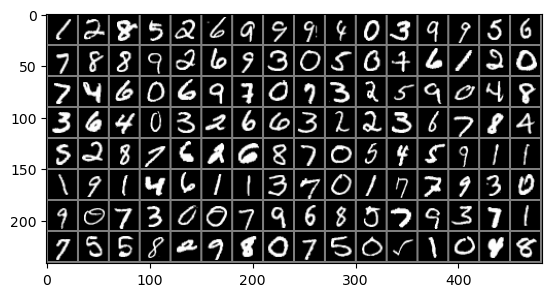

In [8]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

### WGAN

In [9]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )
        self.prob = nn.Sigmoid()

    def forward(self, input):
        return self.prob(self.main(input).view(-1, 1).squeeze(1))

# Create some generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

### Display samples of the Generator

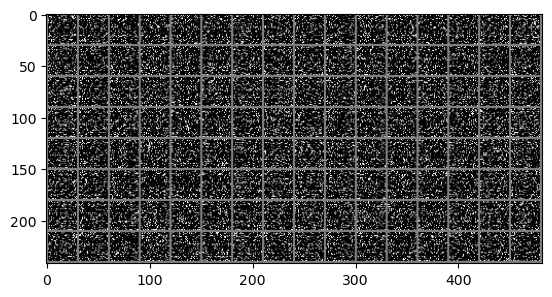

In [ ]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
      # print(f"z = {z.size()}")
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

# Load a pre-learned generator to see what you will get at the end of the practical session!:
G = Generator().to(device)
# G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))

# Display samples
show(G)

### Weigths Initialization

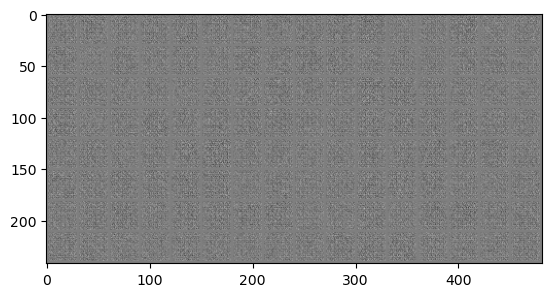

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G)

### Specific Training loop - WGAN with Gradient Penalty for MNIST

In [81]:
# small dataloader to test the pipeline

# N_SMALL = 500
# subset_indices = range(N_SMALL)
# subset = Subset(train_set, subset_indices)

# sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [82]:
def est_gradient_norm(n_samples=10):
    # Estimate Gradient of Discriminator on n_samples points
            
    # Sample points from the generator
    z = torch.randn(n_samples,nz,1,1).to(device)
    x_fake_sampled = G(z) # shape : N x 1 x 28 x 28
    # print(f"x_real = {x_real.size()}")
    # print(f"x_fake_sampled = {x_fake_sampled.size()}")
            
    # # Calculate interpolation between data and generated points
    alpha = torch.rand((n_samples,1,1,1),device=device) # N x 1 x 1 x 1
    # print(f"alpha = {alpha.size()}")
    # print(f"exemple alpha = {alpha[0]}")
    interp = (alpha * x_fake_sampled + (1-alpha) * x_real[:n_samples,:,:,:]) # N x 1 x 28 x 28
    # print(f"interp = {interp.size()}")
    interp.requires_grad_()
            
    D_interp = D(interp) # N x 1
    # print(f"D_interp = {D_interp.size()}")
    gradout = torch.ones(D_interp.size()).to(device) # N x 1
    # print(f"gradouts = {gradout.size()}") # N x 1
    # autograd will actually compute a Gradient tensor N x 1 x 28 x 28, 
    # as output is D_interp shape B
    # and input is interp shape N x 1 x 28 x 28
    # ----
    # gradients is shape N x 1 x 28 x 28
    gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 1 x 28 x 28
    # print(f"gradients = {gradients.size()}")
    # -----
    # compute gradient norm estimate
    norms_squared = torch.sqrt(torch.sum(gradients**2,(2,3))) # B x 1 
    # print(f"norms_squared = {norms_squared.size()}")
    est_gradient_norm = torch.mean(norms_squared) #  1
    # print(est_gradient_norm)
    
    return est_gradient_norm

# est_gradient_norm()

In [89]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 10
log_every = 100
gpw = 5

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

niterD = 10

In [90]:
t0 = time.time()
list_gradient_norms = []
Dlosses = []
Dlosses_wogp = []
Glosses = []
Gradient_norms = []

for epoch in range(num_epochs):
    # For each batch in the train_loader
    losses_d_batch = []
    losses_d_wogp_batch = []
    losses_g_batch = []
    gradient_norms_batch = []
    
    for i, batch in enumerate(train_loader, 0):
         
        # losses_batch = []
        # gradient_norm_batch = []

        ############################
        # Draw Batches 
        ############################
        
        x_real = batch[0].to(device)  # B x 1 x 28 x 28
        # print(f"x_real = {x_real.size()}")
        
        x_fake = G(torch.randn(batch_size,nz,1,1).to(device)) # B x 1 x 28 x 28
        # print(f"x_fake = {x_fake.size()}")
        
        ################################
        # Train Discriminator 
        ################################
        
        for j in range(niterD):
            # print(f"Discriminator training {j+1} / {niterD}", end="\r")
            
            optimD.zero_grad()
            # Dloss sans gradient penalty : best is -1, worst is 1
            # loss sans la régul gradient penalty
            Dloss_wogp = - (torch.mean(D(x_real)) - torch.mean(D(x_fake)))
            
            gradient_norm = est_gradient_norm()
            
            # calculate the loss with gradient penalty
            Dloss = Dloss_wogp + gpw * (gradient_norm - 1)**2
                        
            # optimize
            optimD.zero_grad()
            Dloss.backward(retain_graph=True)
            optimD.step()
          
        # iteration losses log
        losses_d_wogp_batch.append(Dloss_wogp.item())
        losses_d_batch.append(Dloss.item())
        gradient_norms_batch.append(gradient_norm.item())
    
        ############################
        # Update G network
        ############################
        
        # Gloss : best is -1, worst is 0
        Gloss = - torch.mean(D(G(torch.randn(batch_size,nz,1,1).to(device))))
        optimG.zero_grad()
        Gloss.backward()
        optimG.step()
        
        losses_g_batch.append(Gloss.item())
        
        # reporting
        print(f"batch {i+1} / {len(train_loader)} \
            -- avg D loss sans GP = {np.average(losses_d_wogp_batch):.4f} \
            -- avg G loss = {np.average(losses_g_batch):.4f} \
            -- Gradient norm estimate : {gradient_norm:.4f}", \
            end="\r")
        
        ##############################
        ## Log 
        ##############################
        
    loss_d_wogp_epoch = np.average(losses_d_wogp_batch)
    loss_d_epoch = np.average(losses_d_batch)
    loss_g_epoch = np.average(losses_g_batch)
    gradient_norm_epoch = np.average(gradient_norms_batch)
    
    Dlosses_wogp.append(loss_d_wogp_epoch)
    Dlosses.append(loss_d_epoch)
    Glosses.append(loss_g_epoch)
    Gradient_norms.append(gradient_norm_epoch)
       
    print(f"epoch : {epoch+1} / {num_epochs} \
        --- loss D sans GP = {loss_d_wogp_epoch:.4f} \
        --- loss G = {loss_g_epoch:.4f} \
        --- gradient norm = {gradient_norm_epoch:.4f} \
                                                                ")
    

with torch.no_grad():
    z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))

tlt = time.time()-t0
print(f'Total learning time = {tlt:.4f}')

# # Save final generator in a variable for later use
# wgan = Generator()
# wgan.load_state_dict(G.state_dict())

# # Save final generator in a file
# torch.save(G.state_dict(), 'wgan.pt')

KeyboardInterrupt: 

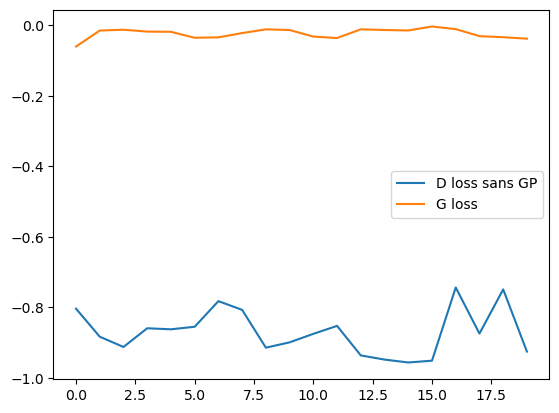

In [19]:
plt.plot(Dlosses_wogp, label="D loss sans GP")
plt.plot(Glosses, label='G loss')
plt.legend()

plt.show()

# VAE

In [268]:
import torch.distributions as td

In [269]:
latent_dim = 16
hidden_dim = 288

In [270]:
class Encoder2D(nn.Module):
        def __init__(self):
                super(Encoder2D, self).__init__()
                self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
                self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
                self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, padding=3)
                n = hidden_dim # 32 x 3 x 3
                self.fc = nn.Linear(n, latent_dim*2)
                
        def forward(self,inputs):
                # input is B x 1 x 28 x 28
                # s = inputs.shape
                # x = inputs.view(s[0], 1, s[1], s[2]) # out = B x 1 x 28 x 28
                x = self.conv1(inputs) # out : B x 16 x 28 x 28
                x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 16 x 14 x 14
                x = self.conv2(x) # out : batch x 32 x 14 x 14
                x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 32 x 7 x 7
                x = self.conv3(x) # out : B x 32 x 7 x 7
                x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 32 x 3 x 3
                x = x.view((x.size()[0], -1)) # out : B x 288
                x = self.fc(x) # out : batch x latent_dim * 2
                return x
        
encoder = Encoder2D()

In [271]:
# checking dimensions...
# 
batch_example_size = 8

x = torch.randn((batch_example_size,1,28,28))
print(f"input = {x.shape}")
print(f"output = {encoder(x).shape}")

input = torch.Size([8, 1, 28, 28])
output = torch.Size([8, 32])


In [272]:
# # sampling from the posterior !
# #
# n_samples = 3

# z_sample_reparametrized = q_zgivenx.rsample((n_samples,))
# print(f"z_posterior sample = {z_sample_reparametrized.shape}")

In [273]:
# Decoder to sample back from vector latent_dim to 28 x 28

class Decoder2D(nn.Module):
        def __init__(self):
                super(Decoder2D, self).__init__()
                n_hidden = hidden_dim
                self.fc1 = nn.Linear(latent_dim, n_hidden)
                self.deconv1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1)
                self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
                self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=7, stride=2, padding=1, output_padding=1)
                # self.fc2 = nn.Linear(32*16*16, 2*257*9)
                
        def forward(self, inputs):
                B = inputs.size(0)  # number of batches
                x = inputs # out = B x latent_dim
                x = F.relu(self.fc1(x)) # out : B x (hidden_dim)
                x = x.reshape(x.shape[0], 32, 3, 3) # out B * 32 * 3 * 3
                x = self.deconv1(x) # out : B x 32 x 3 x 3
                x = self.deconv2(x) # out : B x 32 x 6 x 6
                x = self.deconv3(x) # out : B x 32 x 12 x 12
                x = self.deconv4(x) # out : B x 32 x 28 x 28
                # x = x.reshape(K, B, 28, 28) # out : K x B x NX x NY x NZ
                
                return x
        
decoder = Decoder2D()

In [274]:
# check dimensions

x = torch.randn(8, latent_dim) # B (batch size) x latent_dim
print(f"input shape = {x.shape}")
print(f"output shape = {decoder(x).shape}")

input shape = torch.Size([8, 16])
output shape = torch.Size([8, 1, 28, 28])


In [283]:
# prior - .rsample() uses the reparametrization trick (see Kingma 2014)
p_z = td.Independent(
    td.Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim)),
    reinterpreted_batch_ndims=1
    )

# sampling
z_samples_from_prior = p_z.rsample()
print(f"z_samples_from_prior = {z_samples_from_prior.shape}")
# p_xgivenz = td.Independent(
#     td.Bernoulli(logits = decoder(z_samples_from_prior)), 
#     reinterpreted_batch_ndims = 3
# )
# print(f"x given z = {p_xgivenz}")
# print(f"x_given z batch_shape = {p_xgivenz.batch_shape}")
# print(f"x_given z event_shape = {p_xgivenz.event_shape}")
# x_samples = p_xgivenz.sample((1,))
# print(f"x_samples = {x_samples.shape}")

z_samples_from_prior = torch.Size([16])


In [276]:
# # number of samples to estimate the expactation in the loss calculation
# K = 5

# print(f"batch_size = {batch_size}")
# print(f"samples size = {K}")
# batch_ps, batch_label = next(iter(train_loader))

# # batch_to_tensors = convert_batch_to_tensors_3d(batch_ps)
# print(f"Tensors 2D batch = {batch_ps.shape}")

# # encode
# encoded_batch = encoder(batch_ps)
# print(f"encoded batch dans l'espace latent = {encoded_batch.shape}")

# # parameters
# mu_q = encoded_batch[:,:latent_dim]
# sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
# print(f"mu = {mu_q.shape}")
# print(f"sigma_q = {sigma_q.shape}")

# # posterior
# q_zgivenx = td.Independent(
#     td.Normal(loc=mu_q, scale=sigma_q),
#     reinterpreted_batch_ndims=1
# )
# print(f"posterior z|x = {q_zgivenx}")

# # sampling posterior samples
# z_sample_reparametrized = q_zgivenx.rsample((K,))
# print(f"z_samples_reparametrized samplés = {z_sample_reparametrized.shape}")

# # observation model
# p_xgivenz = td.Independent(
#     td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
#     reinterpreted_batch_ndims=3
# )
# print(f"observation models x|z = {p_xgivenz}")

# # computing the loss !!
# print(f"batch squeezed = {batch_ps.permute(1,0,2,3).size()}")
# log_weights = p_xgivenz.log_prob(batch_ps.permute(1,0,2,3)) # + p_z.log_prob(z_sample_reparametrized) - q_zgivenx.log_prob(z_sample_reparametrized) 
# print(log_weights = {log_weights.size()})

# # iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
# # print(f"Loss = {iwae_bound.detach().numpy()}")

In [ ]:
# encoder = Encoder3D()
# decoder = Decoder3D()

# device = torch.device("cuda") 
# decoder.to(device)
# encoder.to(device)

In [ ]:
# losses = []

# for epoch in range(epochs):
#         # loop on epochs
#         data_iter = iter(data_loader)
#         total_bn = len(data_iter)
        
#         # loop on batches
#         cumul_loss = 0
        
#         for bn, (batch_ps, batch_label) in enumerate(data_iter):
            
#             # measure
        
#             # go GPU
#             batch_ps = batch_ps.to(device)
#             optimizer.zero_grad()
                      
#             # encode in latent space        
#             encoded_batch = encoder(batch_ps)
#             mu_q = encoded_batch[:,:latent_dim]
#             sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
            
#             # compute posterior distribution
#             q_zgivenx = td.Independent(
#                 td.Normal(loc=mu_q, scale=sigma_q),
#                 reinterpreted_batch_ndims=1
#                 )
            
#             # sample posterior samples
#             z_sample_reparametrized = q_zgivenx.rsample((K,)).to(device)
            
#             # compute observations distributions
#             p_xgivenz = td.Independent(
#                 td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
#                 reinterpreted_batch_ndims=3
#                 )
            
#             # compute loss
#             # Mais où sont les tenseurs....            
#             # print(p_xgivenz.log_prob(batch_to_tensors).is_cuda) # True
#             # print(z_sample_reparametrized.is_cuda) # True
#             # print(p_z.log_prob(z_sample_reparametrized.to('cpu')).is_cuda)  # False
#             # print(p_z.log_prob(z_sample_reparametrized.to('cpu')).to(device).is_cuda)  # True
#             # print(q_zgivenx.log_prob(z_sample_reparametrized).to(device).is_cuda) # True
            
#             log_weights = p_xgivenz.log_prob(batch_ps) + p_z.log_prob(z_sample_reparametrized.to('cpu')).to(device) - q_zgivenx.log_prob(z_sample_reparametrized).to(device) 
#             iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
#             # print(f"Loss = {iwae_bound.item()}")
            
#             # gradient descent
#             loss = - iwae_bound
#             loss.backward()
#             optimizer.step()

#             # Log and ipdate progress report
#             cumul_loss += loss.item()
#             print(f"Epoch {epoch+1}/{epochs} - Batch {bn+1}/{total_bn} - loss = {loss.item():.2f}", end="\r")
        
#         # next epoch
#         epoch_loss = cumul_loss / total_bn
#         print(f"Epoch {epoch+1}/{epochs} terminée - loss moyenne = {epoch_loss:.2f}")
#         losses.append(epoch_loss)

In [ ]:
# fig, ax = plt.subplots(figsize=(16,6))

# ax.plot(np.array(losses))
# ax.set_title(f"Loss VAE vs epoch - {NX}*{NY}*{NZ}")
# ax.set_xlabel(f"Epochs")
# ax.set_ylabel(f"Loss")
# ax.grid(True)
# plt.show()